# Evaluate embeddings using clustering

In [1]:
from anndata import read_h5ad, AnnData

# get 5 clustering methods
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from hdbscan import HDBSCAN


from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [2]:
# read in data
adata = read_h5ad('data/TCGA.HNSC.embedded.h5ad')

In [15]:
def cluster(adata: AnnData, method: str, n_clusters: int):
	if method == "kmeans":
		clusterer = KMeans(n_clusters=n_clusters, n_init=10, max_iter=300, tol=1e-04, random_state=0)
	elif method == "spectral":
		clusterer = SpectralClustering(n_clusters=n_clusters, assign_labels="discretize", random_state=0)
	elif method == "hc":
		clusterer = AgglomerativeClustering(n_clusters=n_clusters)
	elif method == "gmm":
		clusterer = GaussianMixture(n_components=n_clusters, covariance_type='full', reg_covar=1e-4)
	elif method == "hdbscan":
		clusterer = HDBSCAN(min_cluster_size=n_clusters, gen_min_span_tree=True)
	else:
		raise ValueError(f"Unknown clustering method: {method}")
	
	# fit and predict
	return clusterer.fit_predict(adata.X)

In [16]:
# cluster and evaluate
res = {"nclusters":[], "embedding": [], "ncomponents":[], "silhouette":[], "method":[]}

methods = {"KMeans": {KMeans, }}

for emb in ["pca","umap","mds","tsne"]:
	for n in range(6, 11):
		for nc in range(2, 11):
			if nc>3 and emb=="tsne":
				continue
			for method in ["kmeans", "spectral", "hc", "gmm", "hdbscan"]:
				try:
					pred = cluster(adata, method, n)
				except Exception:
					print(f"Failed to cluster {emb} with {nc} components and {n} clusters using {method}")
					continue

				# TODO: add more metrics here (e.g. ARI, NMI)
				res["nclusters"].append(n)
				res["embedding"].append(emb)
				res["ncomponents"].append(nc)
				res["silhouette"].append(silhouette_score(adata.obsm[f"{emb}_{nc}"], pred))
				res["method"].append(method)
				


/Users/mcuoco/projects/ece204_project1/.venv/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


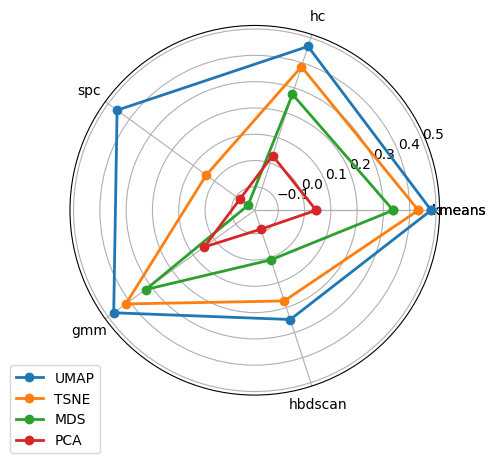

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of variables we want to plot
categories = ['kmeans', 'hc', 'spectral', 'gmm', 'hbdscan']

# Define the scores
scores = [[0.48163313,0.46594062,0.4580641,0.4739896,0.2476447],
          [0.43268022,0.38490242,0.038834833,0.41697946,0.17344864],
          [0.33717433,0.2746031,-0.15712011,0.32373157,0.009185415],
          [0.044381455,0.029471798,-0.11836545,0.048303895,-0.11360475]]

# Calculate the angles for each category
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)

# Make a full circle, with the first and last angles overlapping
angles = np.concatenate((angles, [angles[0]]))

# Initialize the plot
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)

# Add each score as a separate line
for i in range(len(scores)):
    # Duplicate the first score to create a closed loop
    scores[i].append(scores[i][0])
    
    # Add the plot for each score
    ax.plot(angles, scores[i], 'o-', linewidth=2, label="UMAP" if i == 0 else "TSNE" if i == 1 else "MDS" if i ==2 else "PCA")

# Add labels and legends
ax.set_thetagrids(angles * 180/np.pi, np.concatenate((categories,[categories[0]])))
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()


In [3]:
adata

AnnData object with n_obs × n_vars = 545 × 20262
    obs: 'type', 'age_at_initial_pathologic_diagnosis', 'gender', 'race', 'ajcc_pathologic_tumor_stage', 'histological_type', 'histological_grade', 'tumor_status', 'vital_status', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction', 'tissue_source_site'
    var: 'gene', 'n_cells', 'mean', 'std'
    uns: 'log1p'
    obsm: 'mds_1', 'mds_10', 'mds_2', 'mds_3', 'mds_4', 'mds_5', 'mds_6', 'mds_7', 'mds_8', 'mds_9', 'pca', 'pca_1', 'pca_10', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'tsne_1', 'tsne_2', 'tsne_3', 'umap_1', 'umap_10', 'umap_2', 'umap_3', 'umap_4', 'umap_5', 'umap_6', 'umap_7', 'umap_8', 'umap_9'

In [15]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
meta = pd.read_csv('data/TCGA.HNSC.metadata.txt', sep='\t', header=0, index_col=0)
print("meta data shape: ", meta.shape)
metadata = meta.fillna("Unknown")
x= metadata['gender'].values
x=pd.Categorical(x).codes

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x)

# Apply k-means clustering with k=7 clusters
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_pca)


cluster_labels = kmeans.predict(X_pca)
print(cluster_labels)

print(silhouette_score(X_pca,cluster_labels))

meta data shape:  (500, 18)


ValueError: Expected 2D array, got 1D array instead:
array=[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0.
 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [13]:
metadata['histological_grade']

patient_id
TCGA-4P-AA8J    G2
TCGA-BA-4074    G3
TCGA-BA-4075    G2
TCGA-BA-4076    G2
TCGA-BA-4077    G2
                ..
TCGA-UF-A7JT    G3
TCGA-UF-A7JV    G2
TCGA-UP-A6WW    G2
TCGA-WA-A7GZ    G2
TCGA-WA-A7H4    G3
Name: histological_grade, Length: 500, dtype: object